# Clustering 

군집화 알고리즘과 군집 평가 방법을 공부해보자.

---

helper function

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [68]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    
    # 군집별 중심 위치: K-Means, Mean Shift 등
    if iscenter:
        centers = clusterobj.cluster_centers_
    
    # Cluster 값 종류
    unique_labels = np.unique(dataframe[label_name].values)
    
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        # 군집별 데이터 프레임
        label_cluster = dataframe[dataframe[label_name]==label]
        
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else:
            cluster_legend = 'Cluster '+str(label)
        
        # 각 군집 시각화
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        # 군집별 중심 위치 시각화
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
            
    if isNoise:
        legend_loc='upper center'
    else: 
        legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

### K-Means

Clustering에서 가장 일반적으로 사용되는 알고리즘.  
군집 중심점(centroid)이라는 특정한 임의의 지점을 선택해 해당 중심에 가장 가까운 포인트들을 선택하는 군집화 기법.



모든 데이터 포인트에서 더 이상 중심점의 이동이 없을 경웨 iteration을 멈추고, 해당 중심점에 속하는 데이터 포인트들을 군집화함

장점  
- 매우 빠름 
- linear complexity O(n)  
  
단점  
- have to select how many groups/classes there are. (자율주행에서는 불가능에 가까움)  
- it may yield different clustering results on different runs of the algorithm  
  Thus, 그때그때 결과가 다를 수 있음..!

---

### GMM (Gaussian Mixture Model)

군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포 (Gaussian Distribution)를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식    
- 가령 1000개의 데이터 세트가 있다면 이를 구성하는 여러 개의 정규 분포 곡선을 추출하고, 개별 데이터가 이 중 어떤 정규 분포에 속하는지 결정하는 방식  


모수 추정 방법  
- 개별 정규 분포의 평균과 분산  
- 각 데이터가 어떤 정규 분포에 해당하는지의 확률  

이러한 모수 추정을 위해 GMM은 EM(Expectation and Maximization) 방법을 적용함. (To study)


GMM -> 확률 기반 군집화  
K-Means -> 거리 기반 군집화  


GMM의 경우 KMeans보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있다는 장점이 있음.

In [109]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [110]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64


----

### K-Means

원형의 범위에서 군집화를 수행  
데이터 세트가 원형의 범위를 가질수록 KMeans의 군집화 효율은 더욱 높아짐

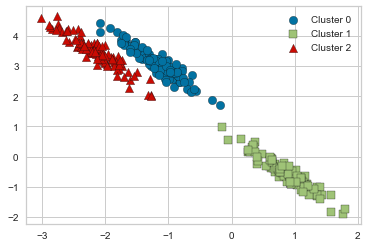

In [70]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X_aniso = np.dot(X, transformation)

clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

----

### Mean Shift

K-means와 유사하게 중심을 군집의 중심으로 지속적으로 움직이면서 군집화를 수행함.  
K-means가 중심에 소속된 데이터의 평균 거리 중심으로 이동하는데 반해, Mean Shift는 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킴.  

- 가장 집중적으로 데이터가 모여있어 확률 밀도 함수가 peak인 점을 군집 중심점으로 선정하며 일반적으로 주어진 모델의 확률 밀도 함수(PDF, Probability Density Function)를 찾기 위해서 KDE(Kernel Density Estimation)을 이용함.  
- 특정 데이터 반경 내의 데이터 분포 확률 밀도가 가장 높은 곳으로 이동하기 위해 주변 데이터와의 거리 값을 KDE 함수 값으로 입력한 뒤, 그 반환 값을 현재 위치에서 업데이트하면서 이동하는 방식을 취함.  
  이러한 방식을 전체 데이터에 반복적으로 적용하면서 데이터의 군집 중심점을 찾아냄.

장점:  
- 데이터 세트의 형태를 특정 형태로 가정한다든가, 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화가 가능함  
- 이상치의 영향력도 크지 않음  
- 미리 군집의 개수를 정할 필요도 없음  

아쉬운 점:  
- 알고리즘 수행 시간이 오래 걸리고 무엇보다도 band-width의 크기에 따른 군집화 영향도가 매우 큼  

=> 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어난 역할을 수행하는 알고리즘 임.

In [71]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print(f'cluster labels class: {np.unique(cluster_labels)}')

cluster labels class: [0 1 2 3 4 5]


=> 군집이 0~5까지 6개로 분류됨. 지나치게 세분하게 군집화됨  

일반적으로 bandwidth 값을 작게 할수록 군집 개수가 많아짐.

In [72]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print(f'cluster labels class: {np.unique(cluster_labels)}')

cluster labels class: [0 1 2]


=> 데이터 분포 유형에 따라 bandwidth 값의 변화는 군집화 개수에 큰 영향을 미칠 수 있음.  

따라서, MeanShift에서는 이 bandwidth를 최적화 값으로 설정하는 것이 매우 중요함!   
=> sklearn에서 제공하는 estimate_bandwidth()함수를 사용하면 피처 데이터 세트에 최적화된 bandwidth 값을 반환해줌

In [ ]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print(f'bandwidth value : {round(bandwidth,3)}')

bandwidth value : 1.816


In [ ]:
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print(f'cluster labels class : {np.unique(cluster_labels)}')

cluster labels class : [0 1 2]


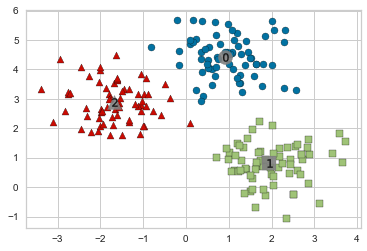

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o','s','^','x','*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    
    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolors='k', marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [ ]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: meanshift_label, dtype: int64


----

### DBSCAN

Density Based Spatial Clustering of Applications with Noise

특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 하고 있어서 복잡한 기하학적 분포도를 가진 데이터 세트에 대해서도 군집화를 잘 수행함  

가장 중요한 두 가지 파라미터  
- epsilon : 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역  
- min points : 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수  


## 군집 평가(Cluster Evaluation)

비지도학습의 특성상 어떠한 지표라도 정확하게 성능을 평가하기는 어려움.  

### 실루엣 분석(Silhouette analysis)

- 각 군집 간의 거리가 얼마나 효율적으로 분리돼 있는지를 나타냄.  
    - 효율적으로 잘 분리됐다는 것은, 다른 군집과의 거리는 떨어져 있고 동일 군집끼리의 데이터는 서로 가깝게 잘 뭉쳐 있다는 의미.  

silhouette coefficient  
: 개별 데이터가 가지는 계수로써, 해당 데이터가 같은 군집 내의 데이터와 얼마나 가깝게 군집화돼 있고, 다른 군집에 있는 데이터와는 얼마나 멀리 분리돼 있는지를 나타내는 지표  

- -1 ~ 1 사이의 값을 가짐  
- 1 : 근처의 군집과 더 멀리 떨어져 있음 (1에 가까울 수록 좋은 결과)  
- 0 : 근처의 군집과 가까워 짐  
- -1 : 아예 다른 군집에 데이터 포인트가 할당됐음...


좋은 군집화가 되려면...
- 실루엣 계수의 평균값이 0 ~ 1 사이의 값을 가지며, 1에 가까울수록 좋다.  
- 개별 군집의 평균값의 편차가 크지 않아야 함. 즉, 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요함.  

In [ ]:
from sklearn.preprocessing import scale 
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(irisDF)
irisDF['cluster'] = kmeans.labels_

score_samples = silhouette_samples(iris.data, irisDF['cluster'])
print(f'silhouette_sample() return values shape : {score_samples.shape}')

irisDF['silhouette_coeff'] = score_samples

average_score = silhouette_score(iris.data, irisDF['cluster'])
print(f'iris Data set Silhouette Analysis Score : {average_score:.3f}')

silhouette_sample() return values shape : (150,)
iris Data set Silhouette Analysis Score : 0.553


In [ ]:
irisDF.head(10)

,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315
3,4.6,3.1,1.5,0.2,1,0.805014
4,5.0,3.6,1.4,0.2,1,0.849302
5,5.4,3.9,1.7,0.4,1,0.748280
6,4.6,3.4,1.4,0.3,1,0.821651
7,5.0,3.4,1.5,0.2,1,0.853905
8,4.4,2.9,1.4,0.2,1,0.752150
9,4.9,3.1,1.5,0.1,1,0.825294


In [ ]:
irisDF.tail(10)

,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
140,6.7,3.1,5.6,2.4,2,0.570234
141,6.9,3.1,5.1,2.3,2,0.410255
142,5.8,2.7,5.1,1.9,0,0.232253
143,6.8,3.2,5.9,2.3,2,0.613247
144,6.7,3.3,5.7,2.5,2,0.567078
145,6.7,3.0,5.2,2.3,2,0.425136
146,6.3,2.5,5.0,1.9,0,0.104171
147,6.5,3.0,5.2,2.0,2,0.314930
148,6.2,3.4,5.4,2.3,2,0.352454
149,5.9,3.0,5.1,1.8,0,0.185442


In [ ]:
irisDF.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

### 실루엣 분석 시각화

Yellowbrick Library (https://www.scikit-yb.org/en/latest/)

예제

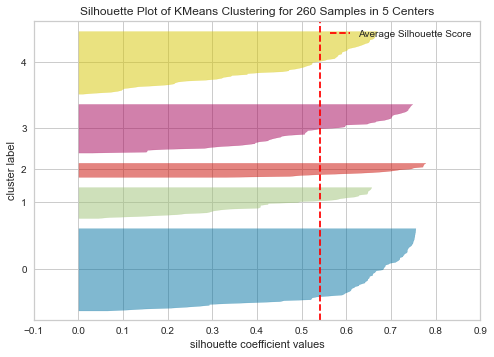

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 260 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl

# Load a clustering dataset
X, y = load_nfl()

# Specify the features to use for clustering
features = ['Rec', 'Yds', 'TD', 'Fmb', 'Ctch_Rate']
X = X.query('Tgt >= 20')[features]

# Instantiate the clustering model and visualizer
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

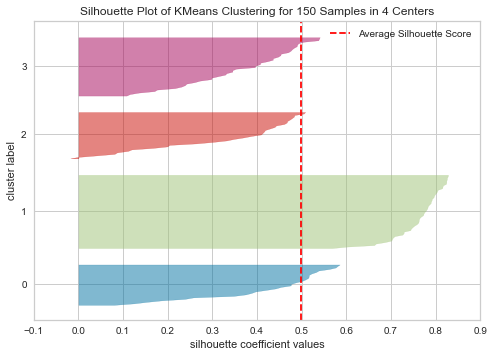

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 150 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
kmeans = KMeans(n_clusters=4, random_state=0)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(irisDF)
visualizer.show()        # Finalize and render the figure

c:\Users\Donggeol.Yang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
c:\Users\Donggeol.Yang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
c:\Users\Donggeol.Yang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=2


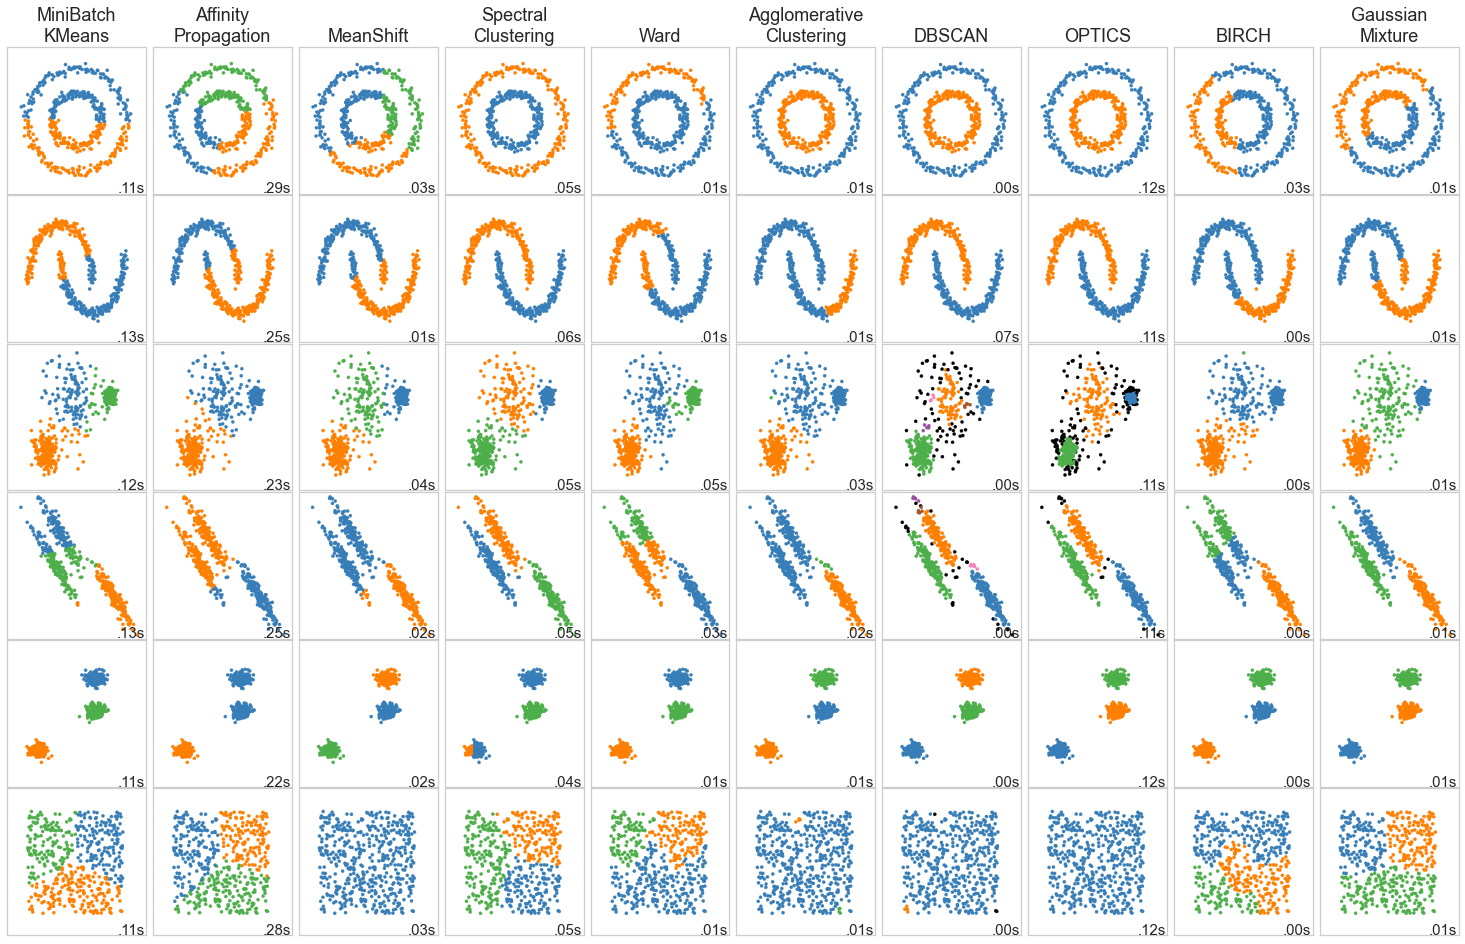

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

---

### Customer Segmentation

In [146]:
dataset_10k = pd.read_csv("../../../input/customer_segmentation/customer_segmentation_10k.csv")

In [147]:
dataset_10k.head()

,customer_id,qtt_order,total_spent,last_order
0,0,370,189719.04,2022-10-30 07:00:00
1,1,48,159092.71,2022-06-30 12:00:00
2,2,4,28239.30,2022-08-21 01:00:00
3,3,157,378630.99,2022-06-30 04:00:00
4,4,16,84763.20,2022-03-18 20:00:00


In [148]:
dataset_10k.last_order = pd.to_datetime(dataset_10k.last_order)
min_date = dataset_10k.last_order.min()
dataset_10k.last_order = dataset_10k.last_order.apply(lambda x: (x-min_date).days)
dataset_10k

,customer_id,qtt_order,total_spent,last_order
0,0,370,189719.04,337
1,1,48,159092.71,215
2,2,4,28239.30,267
3,3,157,378630.99,215
4,4,16,84763.20,112
...,...,...,...,...
9995,9995,30,272219.92,157
9996,9996,5,4997.42,190
9997,9997,324,61504.20,61
9998,9998,142,238317.94,245


In [149]:
df_customer_10k = dataset_10k.drop(['customer_id'], axis=1)
df_customer_10k.head()

,qtt_order,total_spent,last_order
0,370,189719.04,337
1,48,159092.71,215
2,4,28239.30,267
3,157,378630.99,215
4,16,84763.20,112


MeanShift

피처 데이터 세트에 최적화된 bandwidth 값을 사용하여 군집 개수 파악해보기

In [134]:
from sklearn.cluster import estimate_bandwidth

customer_10k_best_bandwidth = estimate_bandwidth(df_customer_10k)
print(f'customer_10k best bandwidth value : {round(customer_10k_best_bandwidth,3)}')

customer_10k_meanshift = MeanShift(bandwidth=customer_10k_best_bandwidth)
cluster_10k_labels = customer_10k_meanshift.fit_predict(df_customer_10k)
print(f'cluster labels class : {np.unique(cluster_10k_labels)}')

customer_10k best bandwidth value : 136819.026
cluster labels class : [0 1]


In [135]:
df_customer_10k['meanshift_label'] = cluster_10k_labels

In [136]:
print(df_customer_10k.groupby('meanshift_label')['meanshift_label'].value_counts())

meanshift_label  meanshift_label
0                0                  9868
1                1                   132
Name: meanshift_label, dtype: int64


In [137]:
meanshift_average_score = silhouette_score(df_customer_10k, df_customer_10k['meanshift_label'])
print(f'Customer Data set Silhouette Analysis Score : {meanshift_average_score:.3f}')

meanshift_score_samples = silhouette_samples(df_customer_10k, df_customer_10k['meanshift_label'])
df_customer_10k['meanshift_silhouette_coeff'] = meanshift_score_samples

df_customer_10k.groupby('meanshift_label')['meanshift_silhouette_coeff'].mean()

Customer Data set Silhouette Analysis Score : 0.770


meanshift_label
0    0.769559
1    0.831181
Name: meanshift_silhouette_coeff, dtype: float64

In [138]:
from sklearn.metrics import davies_bouldin_score

meanshift_davies_bouldin_score = davies_bouldin_score(df_customer_10k, df_customer_10k['meanshift_label'])
print(f'Customer Data set Davies-Boulding Index Score : {meanshift_davies_bouldin_score:.3f}')

Customer Data set Davies-Boulding Index Score : 0.267


In [144]:
from sklearn.metrics import calinski_harabasz_score

meanshift_calinski_harabasz_score = calinski_harabasz_score(df_customer_10k, df_customer_10k['meanshift_label'])
print(f'Customer Data set Calinski-Harabasz Index Score : {meanshift_calinski_harabasz_score:.3f}')

Customer Data set Calinski-Harabasz Index Score : 3582.078


KMenas

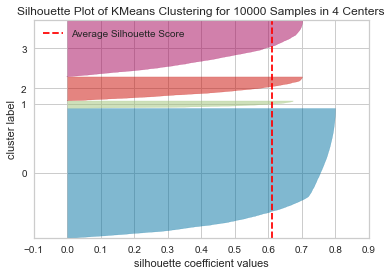

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [150]:
feature_names = ['qtt_order', 'total_spent', 'last_order']
customer_kmeans = KMeans(n_clusters=4, random_state=128)

visualizer = SilhouetteVisualizer(customer_kmeans, colors='yellowbrick')

visualizer.fit(df_customer_10k)
visualizer.show()        # Finalize and render the figure

In [151]:
df_customer_10k['kmeans_cluster'] = customer_kmeans.labels_

kmenas_score_samples = silhouette_samples(df_customer_10k, df_customer_10k['kmeans_cluster'])
print(f'silhouette_sample() return values shape : {df_customer_10k.shape}')

df_customer_10k['silhouette_coeff'] = kmenas_score_samples

kmeans_average_score = silhouette_score(df_customer_10k, df_customer_10k['kmeans_cluster'])
print(f'Customer Data set Silhouette Analysis Score : {kmeans_average_score:.3f}')

silhouette_sample() return values shape : (10000, 4)
Customer Data set Silhouette Analysis Score : 0.611


In [152]:
from sklearn.metrics import davies_bouldin_score

kmenas_davies_bouldin_score = davies_bouldin_score(df_customer_10k, df_customer_10k['kmeans_cluster'])
print(f'Customer Data set Davies-Boulding Index Score : {kmenas_davies_bouldin_score:.3f}')

Customer Data set Davies-Boulding Index Score : 0.528


In [153]:
from sklearn.metrics import calinski_harabasz_score

kmenas_calinski_harabasz_score = calinski_harabasz_score(df_customer_10k, df_customer_10k['kmeans_cluster'])
print(f'Customer Data set Calinski-Harabasz Index Score : {meanshift_calinski_harabasz_score:.3f}')

Customer Data set Calinski-Harabasz Index Score : 3582.078


GMM

In [140]:
from sklearn.mixture import GaussianMixture

customer_gmm = GaussianMixture(n_components=4, random_state=0).fit(df_customer_10k)
customer_gmm_cluster_labels = customer_gmm.predict(df_customer_10k)

df_customer_10k['gmm_cluster'] = customer_gmm_cluster_labels

# customer_gmm_result = df_customer_10k.groupby['gmm_cluster'].value_counts()
# print(customer_gmm_result)

print(df_customer_10k.groupby('gmm_cluster')['gmm_cluster'].value_counts())

gmm_cluster  gmm_cluster
0            0              1982
1            1              4352
2            2               132
3            3              3534
Name: gmm_cluster, dtype: int64


In [141]:
gmm_average_score = silhouette_score(df_customer_10k, df_customer_10k['gmm_cluster'])
print(f'Customer Data set Silhouette Analysis Score : {gmm_average_score:.3f}')

gmm_score_samples = silhouette_samples(df_customer_10k, df_customer_10k['gmm_cluster'])
df_customer_10k['gmm_silhouette_coeff'] = gmm_score_samples

df_customer_10k.groupby('gmm_cluster')['gmm_silhouette_coeff'].mean()

Customer Data set Silhouette Analysis Score : 0.522


gmm_cluster
0    0.236630
1    0.707078
2    0.749470
3    0.445227
Name: gmm_silhouette_coeff, dtype: float64

In [142]:
from sklearn.metrics import davies_bouldin_score

gmm_davies_bouldin_score = davies_bouldin_score(df_customer_10k, df_customer_10k['gmm_cluster'])
print(f'Customer Data set Davies-Boulding Index Score : {gmm_davies_bouldin_score:.3f}')

Customer Data set Davies-Boulding Index Score : 0.530


In [143]:
from sklearn.metrics import calinski_harabasz_score

gmm_calinski_harabasz_score = calinski_harabasz_score(df_customer_10k, df_customer_10k['gmm_cluster'])
print(f'Customer Data set Calinski-Harabasz Index Score : {gmm_calinski_harabasz_score:.3f}')

Customer Data set Calinski-Harabasz Index Score : 17468.454
